# Generation of synthetic EKG signals using GANs and Neurokit library

In [12]:
!nvidia-smi

Mon Oct 27 16:14:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX550         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   48C    P0              1W /   30W |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 0. Generating the database with Neurokit2

In [28]:
import torch

torch.cuda.is_available()

True

In [29]:
import pandas as pd
import os
import random
import numpy as np
import warnings
import neurokit2 as nk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

warnings.filterwarnings("ignore")

In [30]:
# Device selection (GPU if available)
cuda_available = torch.cuda.is_available()
device = torch.device('cuda' if cuda_available else 'cpu')
print('CUDA available:', cuda_available)
print('Device:', device)

CUDA available: True
Device: cuda


In [31]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # For reproducibility (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("PyTorch version:", torch.__version__)

sig = nk.ecg_simulate(
        duration=10,
        sampling_rate=1000,
        heart_rate=70,
        noise=0.01,
        method="ecgsyn"
    )

np.asarray(sig, dtype=np.float32).reshape(-1, 1)

PyTorch version: 2.9.0+cu126


array([[1.0904962 ],
       [1.0861931 ],
       [1.0763634 ],
       ...,
       [0.04311014],
       [0.04309684],
       [0.04321124]], shape=(10000, 1), dtype=float32)

In [32]:
# Semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dependencias
print("PyTorch version:", torch.__version__)

# --------------------------------------------------------
# 1) Generación de dataset sintético con neurokit2
# --------------------------------------------------------
def simulate_ecg_sample(duration_s=8, fs=1000, hr_bpm=70, noise=0.01):
    # ECG sintético; método ecgsyn de neurokit2
    sig = nk.ecg_simulate(
        duration=duration_s,
        sampling_rate=fs,
        heart_rate=hr_bpm,
        noise=noise,
        method="ecgsyn"
    )
    # Aseguramos forma (T, 1) y float32
    x = np.asarray(sig, dtype=np.float32).reshape(-1, 1)
    # Normalización por muestra (z-score)
    m = x.mean()
    s = x.std() + 1e-8
    x = (x - m) / s
    return x

def make_dataset(n_per_class=100, duration_s=8, fs=200, seed=SEED):
    rng = np.random.default_rng(seed)
    classes = {
        "normal": {"hr_range": (60, 80), "noise": (0.005, 0.02)},
        "bradicardia": {"hr_range": (35, 50), "noise": (0.005, 0.02)},
        "taquicardia": {"hr_range": (100, 130), "noise": (0.005, 0.02)},
    }
    X, y, names = [], [], list(classes.keys())

    for label, cfg in enumerate(names):
        hr_lo, hr_hi = classes[cfg]["hr_range"]
        nz_lo, nz_hi = classes[cfg]["noise"]
        for _ in range(n_per_class):
            hr = float(rng.uniform(hr_lo, hr_hi))
            nz = float(rng.uniform(nz_lo, nz_hi))
            x = simulate_ecg_sample(duration_s=duration_s, fs=fs, hr_bpm=hr, noise=nz)
            X.append(x)
            y.append(label)

    # Aseguramos misma longitud (por si hubiese ligeras variaciones)
    T = int(duration_s * fs)
    X = [xi[:T] if len(xi) >= T else np.pad(xi, ((0, T-len(xi)), (0, 0))) for xi in X]
    X = np.stack(X, axis=0).astype(np.float32)   # (N, T, 1)
    y = np.array(y, dtype=np.int64)
    return X, y, names

# Parámetros del dataset
N_PER_CLASS = 100    # Ajusta si quieres más datos
DURATION_S   = 8
FS           = 200

X, y, class_names = make_dataset(
    n_per_class=N_PER_CLASS,
    duration_s=DURATION_S,
    fs=FS,
    seed=SEED
)
N, T, C = X.shape
num_classes = len(class_names)
print(f"Dataset: {N} muestras, secuencia {T}x{C}, clases: {class_names}")



PyTorch version: 2.9.0+cu126
Dataset: 300 muestras, secuencia 1600x1, clases: ['normal', 'bradicardia', 'taquicardia']
Dataset: 300 muestras, secuencia 1600x1, clases: ['normal', 'bradicardia', 'taquicardia']


In [33]:
X.shape

(300, 1600, 1)

In [34]:
X[0], X[0].shape

(array([[ 4.092594 ],
        [ 3.7361026],
        [ 2.842312 ],
        ...,
        [-1.916252 ],
        [-1.6755177],
        [-1.4365792]], shape=(1600, 1), dtype=float32),
 (1600, 1))

In [35]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [36]:
# Train/Val/Test split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED
)
print(f"Split -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


Split -> train: 210, val: 45, test: 45


In [37]:
X_train.shape, y_train.shape

((210, 1600, 1), (210,))

In [38]:
import matplotlib.pyplot as plt

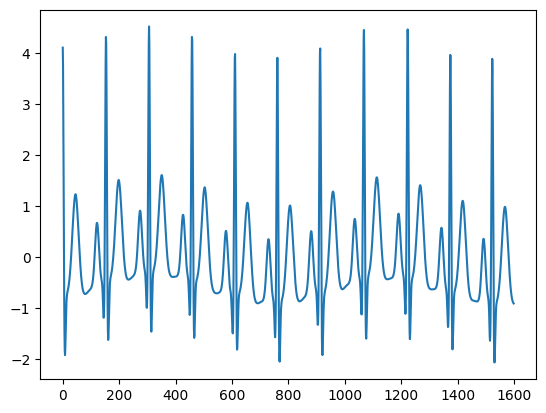

In [39]:
plt.plot(X_train[2][:,0])

## 1. Understanding of the bussiness

## 2. Understanding the data

## 3. Preparing the model

In [46]:
# --------------------------------------------------------
# 2) Modelo LSTM (PyTorch)
# --------------------------------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, seq_len, n_channels, n_classes):
        super().__init__()
        self.hidden_size1 = 64
        self.hidden_size2 = 32
        # first bidirectional LSTM (returns sequences)
        self.lstm1 = nn.LSTM(input_size=n_channels, hidden_size=self.hidden_size1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.3)
        # second LSTM (not bidirectional to mimic keras second Bidirectional with single return)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size1 * 2, hidden_size=self.hidden_size2, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.hidden_size2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        # x: (batch, seq_len, n_channels)
        x, _ = self.lstm1(x)  # (batch, seq_len, hidden_size1*2)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)  # hn shape: (num_layers, batch, hidden_size2)
        h_last = hn[-1]  # (batch, hidden_size2)
        x = self.dropout2(h_last)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
EPOCHS = 100
BATCH = 32

# Instantiate model
model = LSTMClassifier(seq_len=T, n_channels=C, n_classes=num_classes).to(device)
print(model)

# Prepare DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_ds = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping setup
best_val_loss = float('inf')
patience = 5
wait = 0
best_path = 'best_model.pth'

# Training loop
for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            l = criterion(logits, yb).item()
            val_losses.append(l)

    train_loss = np.mean(train_losses) if len(train_losses) else 0.0
    val_loss = np.mean(val_losses) if len(val_losses) else 0.0
    # Calculate accuracy
    model.eval()
    with torch.no_grad():
        # Train accuracy
        train_correct = 0
        train_total = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            _, predicted = torch.max(logits, 1)
            train_total += yb.size(0)
            train_correct += (predicted == yb).sum().item()
        train_acc = train_correct / train_total
        
        # Validation accuracy
        val_correct = 0
        val_total = 0
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            _, predicted = torch.max(logits, 1)
            val_total += yb.size(0)
            val_correct += (predicted == yb).sum().item()
        val_acc = val_correct / val_total

    print(f'Epoch {epoch}/{EPOCHS} - train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping triggered')
            break

# Load best model
model.load_state_dict(torch.load(best_path))
model.to(device)
model.eval()



LSTMClassifier(
  (lstm1): LSTM(1, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)
Epoch 1/100 - train_loss: 1.1021 - train_acc: 0.3333 - val_loss: 1.1027 - val_acc: 0.3333
Epoch 1/100 - train_loss: 1.1021 - train_acc: 0.3333 - val_loss: 1.1027 - val_acc: 0.3333
Epoch 2/100 - train_loss: 1.0994 - train_acc: 0.3333 - val_loss: 1.1021 - val_acc: 0.3333
Epoch 2/100 - train_loss: 1.0994 - train_acc: 0.3333 - val_loss: 1.1021 - val_acc: 0.3333
Epoch 3/100 - train_loss: 1.0994 - train_acc: 0.3333 - val_loss: 1.1015 - val_acc: 0.3333
Epoch 3/100 - train_loss: 1.0994 - train_acc: 0.3333 - val_loss: 1.1015 - val_acc: 0.3333
Epoch 4/100 - train_loss: 1.0999 - train_acc: 0.3429 - val_loss: 1.1000 - val_acc: 0.3333
Epoch 4/100 - train_loss

LSTMClassifier(
  (lstm1): LSTM(1, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)

In [41]:

# --------------------------------------------------------
# 3) Métricas en Test (PyTorch)
# --------------------------------------------------------
model.eval()
all_preds = []
all_probs = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())

y_pred = np.array(all_preds)
probs = np.array(all_probs)

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Métricas finales (Test) ===")
print(f"Accuracy:      {acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f} | Recall (macro): {rec_macro:.4f} | F1 (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec_w:.4f} | Recall (weighted): {rec_w:.4f} | F1 (weighted): {f1_w:.4f}")

print("\n=== Classification report (por clase) ===")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))



=== Métricas finales (Test) ===
Accuracy:      0.2667
Precision (macro): 0.1993 | Recall (macro): 0.2667 | F1 (macro): 0.2058
Precision (weighted): 0.1993 | Recall (weighted): 0.2667 | F1 (weighted): 0.2058

=== Classification report (por clase) ===
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        15
 bradicardia       0.33      0.20      0.25        15
 taquicardia       0.26      0.60      0.37        15

    accuracy                           0.27        45
   macro avg       0.20      0.27      0.21        45
weighted avg       0.20      0.27      0.21        45



In [42]:
print("=== Matriz de confusión ===")
print(pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                      columns=[f"pred_{c}" for c in class_names]))


=== Matriz de confusión ===
                  pred_normal  pred_bradicardia  pred_taquicardia
true_normal                 0                 1                14
true_bradicardia            1                 3                11
true_taquicardia            1                 5                 9


New signal prediction:
Predicted class: taquicardia
Confidence: 0.3444
Class probabilities: {'normal': np.float32(0.31988955), 'bradicardia': np.float32(0.33573532), 'taquicardia': np.float32(0.3443751)}


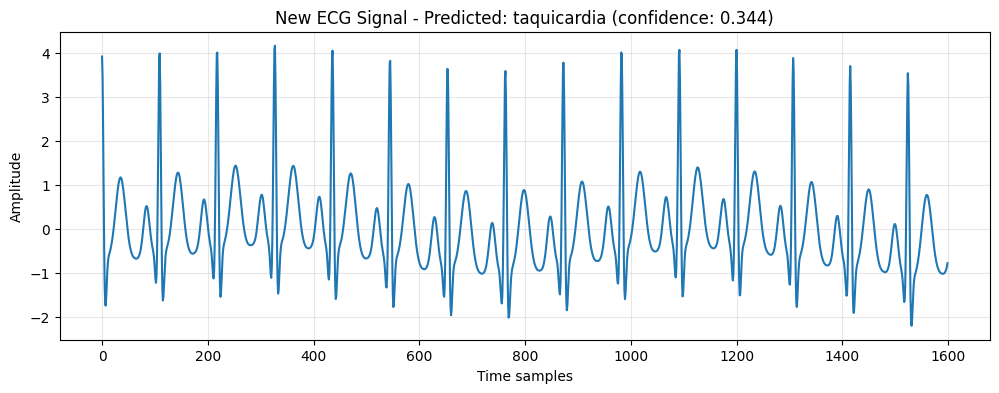

In [43]:
# Generate a new ECG signal for testing
new_signal = simulate_ecg_sample(duration_s=DURATION_S, fs=FS, hr_bpm=110, noise=0.015)

# Reshape for model input (add batch dimension)
new_signal_batch = new_signal.reshape(1, T, C)
new_tensor = torch.from_numpy(new_signal_batch).float().to(device)

# Make prediction
model.eval()
with torch.no_grad():
    logits = model(new_tensor)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    predicted_class = int(np.argmax(probs, axis=1)[0])
    confidence = float(np.max(probs, axis=1)[0])

print(f"New signal prediction:")
print(f"Predicted class: {class_names[predicted_class]}")
print(f"Confidence: {confidence:.4f}")
print(f"Class probabilities: {dict(zip(class_names, probs[0]))}")

# Visualize the new signal
plt.figure(figsize=(12, 4))
plt.plot(new_signal[:, 0])
plt.title(f'New ECG Signal - Predicted: {class_names[predicted_class]} (confidence: {confidence:.3f})')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()